In [1]:
from __future__ import print_function

import numpy as np
from scipy.sparse import lil_matrix

In [2]:
def read_bal_data(file_name):
    with open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [3]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data('./data/ba/ba1.txt')
print("camera_params :", len(camera_params))
print("points_3d :",len(points_3d))
print("camera_indices :",len(camera_indices))
print("point_indices :",len(point_indices))
print("points_2d :",len(points_2d))

camera_params : 49
points_3d : 7776
camera_indices : 31843
point_indices : 31843
points_2d : 31843


In [4]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


In [5]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [6]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [7]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()


In [8]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

In [9]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

In [11]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

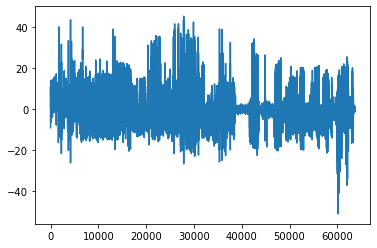

In [12]:
plt.plot(f0)

In [13]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [14]:
import time
from scipy.optimize import least_squares

In [15]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.25e+02       1.54e+04    
       6              9         1.3436e+04      4.55e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.37e+01       6.81e+01       2.19e+03    
       8             11         1.3418e+04      3.71e+00       1.29e+02       7.97e+03    
       9             12         1.3414e+04      4.24e+00       2.64e+01       6.19e+02    

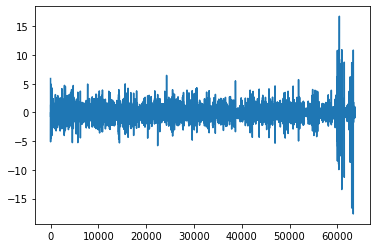

In [16]:
plt.plot(res.fun)

In [17]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 39 seconds


In [18]:
res.x.shape

(23769,)

In [36]:
points_3d[0]

array([-0.61200016,  0.57175905, -1.84708128])

In [31]:
res.x[:21]

array([ 1.76422982e-02, -5.93722339e-03, -7.97127481e-03, -1.44936273e-02,
       -1.13468925e-01,  1.11968336e+00,  3.99920073e+02, -2.44277658e-02,
        1.48762502e-03,  1.76142165e-02, -1.79939982e-02, -1.28040650e-02,
        1.04235070e-02, -1.26980150e-01,  7.19948560e-01,  4.02707672e+02,
       -2.72125275e-02,  3.61252485e-03,  1.59579835e-02,  8.45909417e-04,
       -8.78806374e-03])

In [34]:
for i in range(1,7):
    print(res.x[i*9:i*9+3])
    

[ 0.01761422 -0.017994   -0.01280406]
[ 0.01595798  0.00084591 -0.00878806]
[ 0.01723067 -0.01324772 -0.00535598]
[ 0.01597007  0.00432817 -0.00813982]
[ 0.0147181  -0.01412706 -0.00959245]
[ 0.01525317  0.0060682  -0.00740473]


In [26]:
list(zip(camera_indices, point_indices))

[(0, 0),
 (1, 0),
 (3, 0),
 (26, 0),
 (29, 0),
 (36, 0),
 (0, 1),
 (1, 1),
 (4, 1),
 (8, 1),
 (20, 1),
 (38, 1),
 (47, 1),
 (0, 2),
 (1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (15, 2),
 (17, 2),
 (20, 2),
 (33, 2),
 (35, 2),
 (38, 2),
 (47, 2),
 (0, 3),
 (1, 3),
 (3, 3),
 (5, 3),
 (7, 3),
 (10, 3),
 (11, 3),
 (13, 3),
 (16, 3),
 (22, 3),
 (30, 3),
 (34, 3),
 (39, 3),
 (43, 3),
 (45, 3),
 (0, 4),
 (1, 4),
 (4, 4),
 (6, 4),
 (8, 4),
 (9, 4),
 (12, 4),
 (20, 4),
 (33, 4),
 (35, 4),
 (0, 5),
 (1, 5),
 (2, 5),
 (3, 5),
 (6, 5),
 (0, 6),
 (1, 6),
 (0, 7),
 (1, 7),
 (2, 7),
 (3, 7),
 (4, 7),
 (5, 7),
 (6, 7),
 (7, 7),
 (8, 7),
 (10, 7),
 (11, 7),
 (12, 7),
 (13, 7),
 (15, 7),
 (16, 7),
 (17, 7),
 (20, 7),
 (22, 7),
 (30, 7),
 (34, 7),
 (35, 7),
 (39, 7),
 (43, 7),
 (45, 7),
 (0, 8),
 (1, 8),
 (2, 8),
 (3, 8),
 (4, 8),
 (5, 8),
 (6, 8),
 (7, 8),
 (10, 8),
 (11, 8),
 (13, 8),
 (16, 8),
 (22, 8),
 (30, 8),
 (34, 8),
 (